In [2]:
import unidecode
import string
import random
import re

all_character = string.printable
n_characters = len(all_character)

file = unidecode.unidecode(open(r'C:\Users\Syahrir Ridha\pytorch\recurrent\data\shakespear\shakespear.txt').read())
file_len = len(file)
print('file lenght = {}'.format(file_len))

file lenght = 1115393


In [8]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0,file_len-chunk_len)
    end_index =start_index+chunk_len+1
    return file[start_index:end_index]

print(random_chunk())

he mind too, 'mongst all colours
No yellow in't, lest she suspect, as he does,
Her children not her husband's!

LEONTES:
A gross hag
And, lozel, thou art worthy to be hang'd,
That wilt not stay her ton


In [24]:
# Build the RNN model
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, n_layer):
        super(RNN,self).__init__()
        self.input_size = in_dim
        self.hidden_size = hid_dim
        self.output_size = out_dim
        self.layers = n_layer
        
        self.encoder = nn.Embedding(in_dim,hid_dim)
        self.gru = nn.GRU(hid_dim, hid_dim, n_layer)
        self.decoder = nn.Linear(hid_dim,out_dim)
        
    def forward(self,x,hidden):
        output = self.encoder(x.view(1,-1))
        output, hidden = self.gru(output.view(1,1,-1),hidden)
        output = self.decoder(output.view(1,-1))
        return output,hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.layers,1,self.hidden_size))

In [45]:
# turn strings into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_character.index(string[c])
    return Variable(tensor).view(-1,1)

print(char_tensor('Abhishek'))

tensor([[36],
        [11],
        [17],
        [18],
        [28],
        [17],
        [14],
        [20]])


In [47]:
def random_train_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [69]:
random_train_set()[0].shape, random_train_set()[1].shape

(torch.Size([200, 1]), torch.Size([200, 1]))

In [63]:
def evaluate(prime_str = 'A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    
    # use primimg string to build up the hidden state
    for p in range(len(prime_str)-1):
        _, hidden = decoder(prime_input[p],hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp,hidden)
        
        
        # sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist,1)[0]
        
        # add predicted charactrer to string and use as next input
        predicted_char = all_character[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    
    return predicted

In [64]:
import time, math

def time_since(since):
    s = time.time()-since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds'%(m,s)

In [65]:
def train(inp,target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c],hidden)
        loss += criterion(output,target[c])
        
    loss.backward()
    decoder_optimizer.step()
    
    return loss.item()/chunk_len

In [66]:
# define model variables
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters,hidden_size,n_characters,n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_loss = []
loss_avg = 0

for epoch in range(1,n_epochs+1):
    loss = train(*random_train_set())
    loss_avg += loss
    
    if epoch % print_every==0:
        print('[%s (%d %d%%) %.4f]'%(time_since(start),epoch,epoch/n_epochs*100,loss))
        print(evaluate('Wh',100),'\n')
        
    if epoch % plot_every ==0:
        all_loss.append(loss_avg/plot_every)
        loss_avg = 0

 27s (100 5%) 2.1407]
Whide, dove sour seik and whe leacr perout muule, she and,
The soo! forsot thake not meshesdist, ad?

 

 55s (200 10%) 2.1136]
Whost and thir-orthe the be! I hald the rase man mand
Ang and with cardes forriarte botherss you the V 

 23s (300 15%) 1.8559]
Wh gageser I withen.

BANRD T{ORK:
All ous onfer the reith there reak fait the is hesled at at late!
O 

 52s (400 20%) 2.0535]
Wh your thee mack not I not, cond math on are litiet that mave licemigel to me is hear hy love bok dea 

 20s (500 25%) 1.8206]
Why, chirll eaduntuny is the the the in the andaly here, his chichise cour the be in day thing the thi 

 49s (600 30%) 2.1264]
Whing why falick and the not set whill I wor wars
Here not with have a tin

HARD ENRY TICENILA:
You wi 

 17s (700 35%) 1.8735]
What him:
Were the to the to the wours it to thind their leasther measterself.

CLORETER:
Both thigh I 

 45s (800 40%) 1.9433]
Why brother say him: was lider,
Ad alloof and by yis be not?
Thich am to let will 

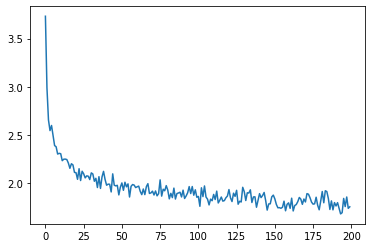

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_loss)